# Project: authorship attribution

## by: Dekel Mor, Matan Ramati


in this project, The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it. our purpose is to classify a text to the most fitting author from number of authors.
This is multi-class text classification problem.

in order to solve our problem we will make research to accomplish a few targets: 
* identify useful features from texts
* finding efficient ways to extract that features 
* explore algorithms to find the most suitable and accurate one for the task

The authorship attribution tool can be useful and powerful. until now we had facial recognition, voice recognition, and fingerprint recognition, all of these cant help when you're stuck with a piece of text.
examples for interesting uses: identify impersonators, recognize criminals by text evidence, protect intellectual property, etc.

the Data will be an array that contains an array of text words and labels (author name).
the source of the data can be Facebook posts, letters, opinion pieces, and other texts that are not in strict formal form.



our required data is a collection of pairs that contains rich text(not formally, because we want to find differences) and the text author identification.
because we wand to classify the text to his author.

we chose to use blog posts data set from here:
https://www.kaggle.com/rtatman/blog-authorship-corpus

the blog posts data set is too big and have too many authors so we to just a sample of 2000 blog posts.



example for text importing and pre process of the data(specifically blog posts):

In [50]:
import nltk
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn as skl
import random 
from nltk import NaiveBayesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
dataset = pd.read_csv('blogtext.csv', delimiter=',', nrows=50000)

In [3]:
dataset.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
# the top 20 authors by number of posts, and the number of posts
dataset['id'].value_counts()[:20]

589736     2294
883178     1616
988941     1542
546850      931
1713442     798
888601      778
3211137     630
2821801     605
1103575     558
766556      532
1926378     473
727002      472
1538911     447
152151      436
1939766     407
1098541     339
299143      328
3581446     315
480727      312
3169212     309
Name: id, dtype: int64

In [5]:
author_list = dataset['id'].value_counts()[:20].index.tolist()

In [6]:
# drop the authors who doesnt in the top 20 list
dataset = dataset[dataset['id'].isin(author_list)]

Text(0.5, 0, 'author id')

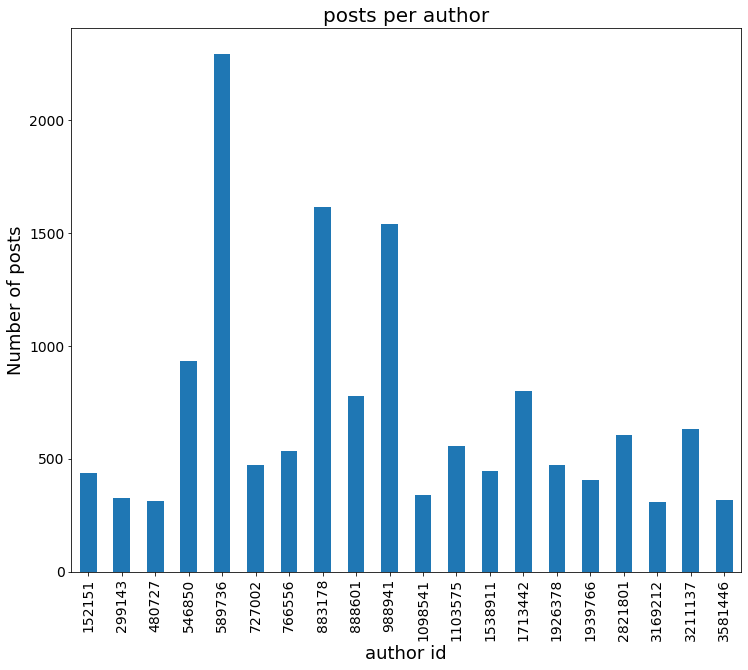

In [7]:
text_group = dataset.groupby('id')
ax=text_group['id'].aggregate(len).plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('posts per author', fontsize=20)
ax.set_ylabel('Number of posts', fontsize=18)
ax.set_xlabel('author id', fontsize=18)

Text(0.5, 0, 'topic')

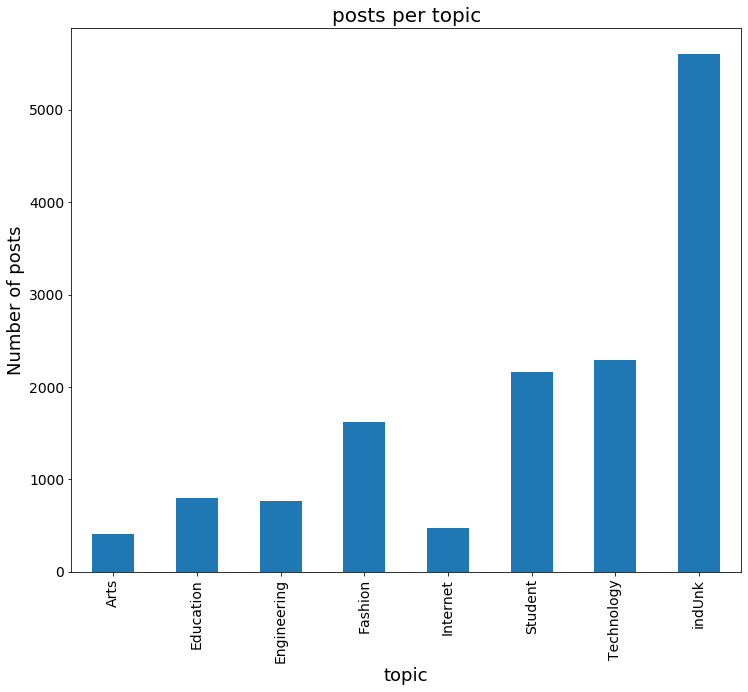

In [25]:
text_group = dataset.groupby('topic')
ax=text_group['topic'].aggregate(len).plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('posts per topic', fontsize=20)
ax.set_ylabel('Number of posts', fontsize=18)
ax.set_xlabel('topic', fontsize=18)

In [9]:
dataset.reset_index(drop=True, inplace=True)

In [10]:
df = pd.DataFrame(columns=["id", "text", "topic"])

breaking the text to word tokens:

In [11]:
tweet_tok = TweetTokenizer(preserve_case=False)
for i in range(len(dataset)):
    df.loc[i] = [dataset.loc[i].id, tweet_tok.tokenize(dataset.loc[i].text), dataset.loc[i].topic]

In [12]:
df

,id,text,topic
0,589736,"[much, funny, ., 2, points, ., as, mentioned, ...",Technology
1,589736,"[harpers, ,, harpers, ,, everywhere, ., harper...",Technology
2,589736,"[in, an, earlier, post, ,, johnathan, said, :,...",Technology
3,589736,"[i'd, post, this, on, the, rtg, blog, ,, but, ...",Technology
4,589736,"[the, answer, to, the, first, question, lies, ...",Technology
...,...,...,...
14117,988941,"[i'm, dying, from, lack, of, sleep, ., got, wo...",Student
14118,988941,"[saw, king, arthur, last, night, ., thumbs, up...",Student
14119,988941,"[i, was, topless, around, 20, mins, ago, ., ha...",Student
14120,988941,"[well, well, i'm, not, topless, so, neeeeeeeee...",Student


filter stopwords("i" "and" "it" etc) and short tokens(with lengh = 1)

In [13]:
stop_words = set(stopwords.words('english'))

for i in range(len(df)):
    df.loc[i].text = [x for x in df.loc[i].text if x not in stop_words and len(x) > 1]  

In [14]:
df

,id,text,topic
0,589736,"[much, funny, points, mentioned, email, game, ...",Technology
1,589736,"[harpers, harpers, everywhere, harpers, harper...",Technology
2,589736,"[earlier, post, johnathan, said, gregory, feel...",Technology
3,589736,"[i'd, post, rtg, blog, can't, post, could, som...",Technology
4,589736,"[answer, first, question, lies, master, Po;, a...",Technology
...,...,...,...
14117,988941,"[i'm, dying, lack, sleep, got, woken, 9:45, to...",Student
14118,988941,"[saw, king, arthur, last, night, thumbs, broug...",Student
14119,988941,"[topless, around, 20, mins, ago, hard, day, to...",Student
14120,988941,"[well, well, i'm, topless, neeeeeeeeeeeeeeeeee...",Student


as part of the research for the project we will try to find more useful features and check how much they contribute to the author prediction.
frequently words, Frequent use of syntax type and etc.

In [15]:
Xfeatures = df['text']
ylabels = df['id']

In [16]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
X = cv.fit_transform(Xfeatures)

In [17]:
x_train,x_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.16,random_state=42)

In [18]:
x_train.shape

(11862, 62406)

In [19]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')
clf = MultinomialNB()
clf.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
print("Accuracy of Model :",clf.score(x_test,y_test))

Accuracy of Model : 0.6092920353982301


In [21]:
logit = LogisticRegression(random_state=0, multi_class="auto", solver='lbfgs')
logit.fit(x_train,y_train)

C:\Users\ramat\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ramat\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print("Accuracy of Logit Model :",logit.score(x_test,y_test))

Accuracy of Logit Model : 0.7628318584070797


## another way to find the best classifier(on smaller part of the dataset, for lack of memory reasons): 

In [46]:
from sklearn.utils import shuffle
sample = dataset[5000:10000]
sample = shuffle(sample)

In [47]:
sample_author_list = sample['id'].value_counts()[1:10].index.tolist()
sample = sample[sample['id'].isin(sample_author_list)]
sample = sample[:1000]

In [48]:
sample['id'].value_counts()

3211137    160
883178     145
1926378    122
727002     118
1538911    115
1939766    102
3581446     84
480727      77
299143      77
Name: id, dtype: int64

In [49]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(sample.text).toarray()
labels = sample.id
features.shape

(1000, 2624)

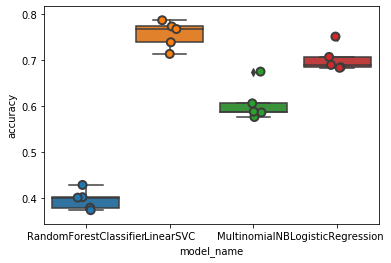

In [51]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, multi_class="auto", solver='lbfgs'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.pyplot.show()

In [52]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.756072
LogisticRegression        0.703228
MultinomialNB             0.606338
RandomForestClassifier    0.396929
Name: accuracy, dtype: float64

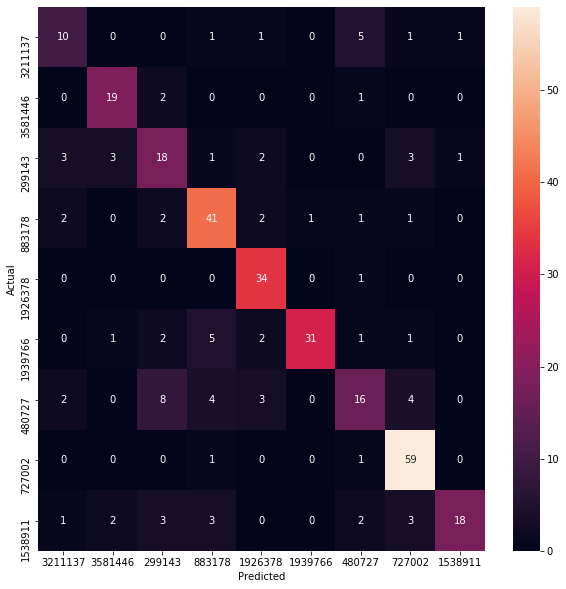

In [53]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, sample.id, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.pyplot.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(sample.id), yticklabels=set(sample.id))
plt.pyplot.ylabel('Actual')
plt.pyplot.xlabel('Predicted')
plt.pyplot.show()

# now we see how it works on hebrew dataset
for the example i chose a few facebook posts of 4 politicans.

In [23]:
heb_dataset = pd.read_csv('ניסיון בדיקה1.csv', delimiter=',')

In [24]:
heb_dataset

,author,text
0,1111,אף אחד לא יסתום לי את הפה!\nיושב ראש הוועידה מ...
1,1111,אני רוצה לספר לכם על יוקר המחיה ולמה פסטה של א...
2,1111,ועדת המשנה ליחסי חוץ והסברה בראשותי מקיימת כעת...
3,1111,עדכון לחוק הכלבת:\nועדת הכלכלה התכנסה היום לדי...
4,2222,להלן כמה נתונים שמחדדים למה ממש חשוב שנשקיע עכ...
5,2222,על רקע משבר הקורונה ועל רקע תהליכי הדיגיטציה ו...
6,2222,בימים אלו אנחנו מבצעים פניות יזומות למאות אלפי...
7,2222,"אנחנו חייבים לדבר על נושא כואב, והוא כמות האנש..."
8,2222,עם כניסתי לתפקיד במשרד לשוויון חברתי וגמלאים ה...
9,3333,סדום ועמורה. \nהחלטת בג״צ למנוע את הרס בית רוצ...


Text(0.5, 0, 'author id')

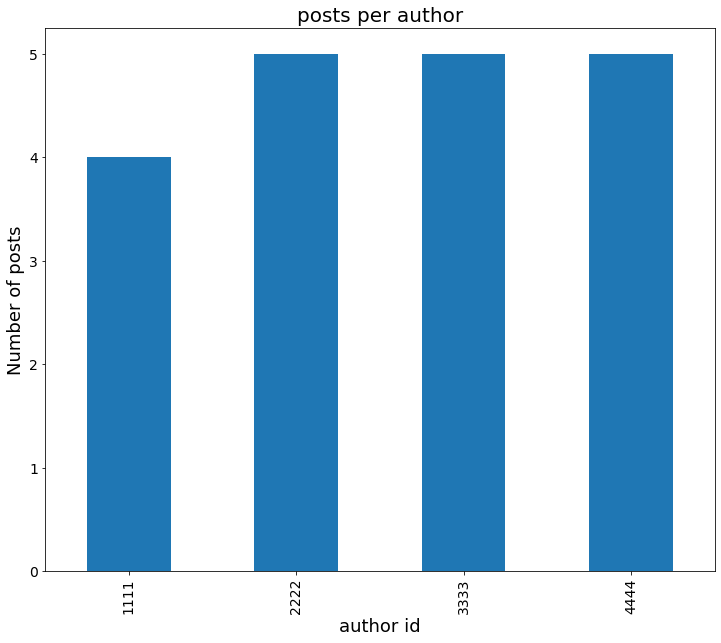

In [27]:
text_group = heb_dataset.groupby('author')
ax=text_group['author'].aggregate(len).plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('posts per author', fontsize=20)
ax.set_ylabel('Number of posts', fontsize=18)
ax.set_xlabel('author id', fontsize=18)

In [28]:
heb_df = pd.DataFrame(columns=["author", "text"])

In [29]:
for i in range(len(heb_dataset)):
    heb_df.loc[i] = [heb_dataset.loc[i].author, tweet_tok.tokenize(heb_dataset.loc[i].text)]

In [30]:
heb_df

,author,text
0,1111,"[אף, אחד, לא, יסתום, לי, את, הפה, !, יושב, ראש..."
1,1111,"[אני, רוצה, לספר, לכם, על, יוקר, המחיה, ולמה, ..."
2,1111,"[ועדת, המשנה, ליחסי, חוץ, והסברה, בראשותי, מקי..."
3,1111,"[עדכון, לחוק, הכלבת, :, ועדת, הכלכלה, התכנסה, ..."
4,2222,"[להלן, כמה, נתונים, שמחדדים, למה, ממש, חשוב, ש..."
5,2222,"[על, רקע, משבר, הקורונה, ועל, רקע, תהליכי, הדי..."
6,2222,"[בימים, אלו, אנחנו, מבצעים, פניות, יזומות, למא..."
7,2222,"[אנחנו, חייבים, לדבר, על, נושא, כואב, ,, והוא,..."
8,2222,"[עם, כניסתי, לתפקיד, במשרד, לשוויון, חברתי, וג..."
9,3333,"[סדום, ועמורה, ., החלטת, בג, ״, צ, למנוע, את, ..."


In [31]:
for i in range(len(heb_df)):
    heb_df.loc[i].text = [x for x in heb_df.loc[i].text if x not in stop_words and len(x) > 1]  

In [32]:
Xfeatures = heb_df['text']
ylabels = heb_df['author']

In [33]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
X = cv.fit_transform(Xfeatures)

In [34]:
x_train,x_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.16,random_state=42)

In [35]:
x_train.shape

(15, 2734)

In [36]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')
clf = MultinomialNB()
clf.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
print("Accuracy of Model :",clf.score(x_test,y_test))

Accuracy of Model : 0.75


## next step is to find more good features that improves our prediction accuracy, to tune the classification algorithms and make them better and consider using Convolutional neural network.